# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190514180936-0000
KERNEL_ID = a8fb1a54-b8e1-4592-94b7-5568154e1a2f


In [2]:
# The code was removed by Watson Studio for sharing.

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Getting rid of Nan values
df.count()

543705

In [4]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

543705

In [5]:
df = df.filter(df.userId!="")
df.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
#Let us get a quick overview of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.describe().show()

+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|     auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|   528005|   528005|528005|            528005|  528005|            432877|528005|          528005|528005| 528005|              

In [8]:
#lets include a time column
import datetime
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [9]:
df = df.withColumn("regdate", get_time(df.registration))

In [10]:
#Lets write some SQL queries
df.createOrReplaceTempView("df")

In [11]:
spark.sql('''SELECT DISTINCT page
          FROM df           
          LIMIT 5000''').show(500)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
spark.sql('''SELECT DISTINCT userID
          FROM df 
          WHERE page == "Cancellation Confirmation"
          Group by userID,page
          LIMIT 5000''').show(5)

+------+
|userID|
+------+
|100010|
|200002|
|   296|
|   124|
|    51|
+------+
only showing top 5 rows



In [13]:
#How many user are in our dataset
spark.sql('''SELECT userID, song, page, sessionID, time 
          FROM df 
          WHERE userID == '10'
          ORDER BY time 
          LIMIT 5000''').show(5)

+------+-------------------+--------+---------+-------------------+
|userID|               song|    page|sessionID|               time|
+------+-------------------+--------+---------+-------------------+
|    10|      Ses Monuments|NextSong|        9|2018-10-08 02:20:20|
|    10|               null|    Home|        9|2018-10-08 02:20:43|
|    10|      Big Jet Plane|NextSong|        9|2018-10-08 02:24:45|
|    10|Act Nice And Gentle|NextSong|        9|2018-10-08 02:28:44|
|    10|               Loca|NextSong|        9|2018-10-08 02:31:21|
+------+-------------------+--------+---------+-------------------+
only showing top 5 rows



In [14]:
#adding the churn column
churn_users = spark.sql('''SELECT DISTINCT userID
          FROM df 
          WHERE page == "Cancellation Confirmation"
          Group by userID
          LIMIT 5000''').collect()

churn_users_list = [(row['userID']) for row in churn_users]

df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

In [15]:
#customers at the start of each month
df_withchurn.createOrReplaceTempView("df_churn")

spark.sql('''SELECT COUNT(DISTINCT userID), MONTH(time) as month, YEAR(time) as year
          FROM df_churn 
          GROUP BY month, year
          ORDER BY year, month
          LIMIT 5000''').show()

+----------------------+-----+----+
|count(DISTINCT userID)|month|year|
+----------------------+-----+----+
|                   430|   10|2018|
|                   383|   11|2018|
|                     4|   12|2018|
+----------------------+-----+----+



In [16]:
#new customers per month 
spark.sql('''SELECT COUNT(DISTINCT userID),MONTH(regdate) as regmonth, YEAR(regdate) as regyear
          FROM df_churn 
          GROUP BY regmonth,regyear
          ORDER BY regyear,regmonth
          LIMIT 5000''').show()

+----------------------+--------+-------+
|count(DISTINCT userID)|regmonth|regyear|
+----------------------+--------+-------+
|                     1|      11|   2017|
|                     1|       2|   2018|
|                     2|       3|   2018|
|                     4|       4|   2018|
|                     5|       5|   2018|
|                    15|       6|   2018|
|                    50|       7|   2018|
|                   116|       8|   2018|
|                   250|       9|   2018|
|                     1|      10|   2018|
|                     3|      11|   2018|
+----------------------+--------+-------+



/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


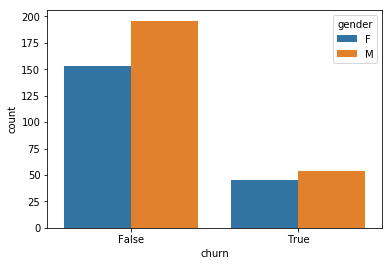

In [17]:
#lets check gender

df_withchurn.createOrReplaceTempView("df_churn")

plot_gender = spark.sql('''SELECT COUNT(DISTINCT userID) as count, gender, churn
          FROM df_churn 
          Group by gender, churn
          ORDER BY churn
          LIMIT 5000''').toPandas()
import seaborn as sns
import matplotlib as plt
sns.barplot(x='churn', y='count', hue='gender', data=plot_gender);

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


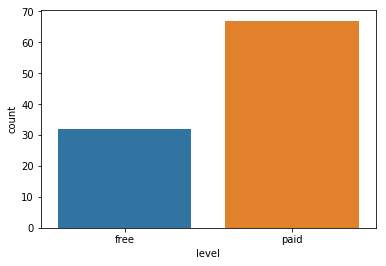

In [18]:
#level
plot_level = spark.sql('''SELECT COUNT(DISTINCT userID) as count, level, churn
          FROM df_churn 
          Where page == "Cancellation Confirmation"
          Group by level, churn
          ORDER BY churn
          LIMIT 5000''').toPandas()

sns.barplot(x='level', y='count', data=plot_level);

In [19]:
#page frequency


spark.sql('''SELECT COUNT(page), page,churn
          FROM df_churn 
          Where page NOT IN ("NextSong") 
          Group by page, churn
          ORDER BY page
          LIMIT 5000''').show(50)

+-----------+--------------------+-----+
|count(page)|                page|churn|
+-----------+--------------------+-----+
|        185|               About| true|
|        841|               About|false|
|       1537|          Add Friend| true|
|       6550|          Add Friend|false|
|       2259|     Add to Playlist| true|
|      10090|     Add to Playlist|false|
|         99|              Cancel| true|
|         99|Cancellation Conf...| true|
|        831|           Downgrade| true|
|       2980|           Downgrade|false|
|        406|               Error|false|
|         97|               Error| true|
|       2127|                Help|false|
|        517|                Help| true|
|       3778|                Home| true|
|      15311|                Home|false|
|       4806|              Logout|false|
|       1184|              Logout| true|
|       5587|         Roll Advert|false|
|       2186|         Roll Advert| true|
|        481|       Save Settings|false|
|        104|   

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
#churn to binary

df_churn_b = spark.sql('''SELECT DISTINCT userID,
          CASE WHEN churn == true THEN 1 ELSE 0 END as churn
          FROM df_churn
          GROUP BY userID, churn
          ORDER BY userID
          ''')

df_churn_b.show()

+------+-----+
|userID|churn|
+------+-----+
|    10|    1|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    1|
|100005|    1|
|100006|    0|
|100007|    0|
|100008|    0|
|100009|    0|
|100010|    1|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    0|
|100016|    1|
|100017|    1|
|100018|    1|
+------+-----+
only showing top 20 rows



In [21]:
#gender
df_gender = spark.sql('''SELECT DISTINCT userID,
          CASE WHEN gender IN ("M") THEN 1 ELSE 0 END as gender
          FROM df_churn
          ORDER BY userID
          ''')
df_gender = df_gender.withColumn('gender', df_gender.gender.cast("int"))


df_gender.show()

+------+------+
|userID|gender|
+------+------+
|    10|     1|
|   100|     1|
|100001|     0|
|100002|     0|
|100003|     0|
|100004|     0|
|100005|     1|
|100006|     0|
|100007|     0|
|100008|     0|
|100009|     1|
|100010|     0|
|100011|     1|
|100012|     1|
|100013|     0|
|100014|     1|
|100015|     0|
|100016|     1|
|100017|     1|
|100018|     1|
+------+------+
only showing top 20 rows



In [22]:
#number of songs played
df_songs_played = spark.sql('''SELECT DISTINCT userID, COUNT(song) as songs
          FROM df_churn
          WHERE song NOT IN ("Null")
          GROUP by userID
          ORDER BY userID
          ''')

df_songs_played.show()

+------+-----+
|userID|songs|
+------+-----+
|    10|  360|
|   100| 3382|
|100001|   96|
|100002|  137|
|100003|  661|
|100004|  262|
|100005|   72|
|100006|  295|
|100007|  853|
|100008|  386|
|100009| 2412|
|100010|   96|
|100011| 1021|
|100012|  112|
|100013|   20|
|100014|  332|
|100015|  381|
|100016|  163|
|100017|  127|
|100018|  124|
+------+-----+
only showing top 20 rows



In [23]:
#thumbs up
df_t_up = spark.sql('''SELECT DISTINCT userID, count(page) as thumbs_up
          FROM df_churn
          WHERE page == "Thumbs Up"
          GROUP BY userID
          ORDER BY userID
          ''')
df_t_up.show()

+------+---------+
|userID|thumbs_up|
+------+---------+
|    10|       17|
|   100|      143|
|100001|        5|
|100002|        8|
|100003|       16|
|100004|       15|
|100005|        2|
|100006|       14|
|100007|       40|
|100008|       19|
|100009|      111|
|100010|        4|
|100011|       33|
|100012|        1|
|100013|        2|
|100014|       14|
|100015|       19|
|100016|        8|
|100017|        9|
|100018|        8|
+------+---------+
only showing top 20 rows



In [24]:
#thumbs down
df_t_down = spark.sql('''SELECT DISTINCT userID, count(page) as thumbs_down
          FROM df_churn
          WHERE page == "Thumbs Down"
          GROUP BY userID
          ORDER BY userID
          ''')
df_t_down.show()

+------+-----------+
|userID|thumbs_down|
+------+-----------+
|    10|          1|
|   100|         37|
|100001|          1|
|100002|          2|
|100003|         10|
|100004|          2|
|100005|          1|
|100006|          3|
|100007|          6|
|100008|          5|
|100009|         26|
|100010|          3|
|100011|         17|
|100012|          2|
|100013|          1|
|100014|          3|
|100015|          6|
|100017|          3|
|100018|          1|
|100019|          3|
+------+-----------+
only showing top 20 rows



In [25]:
#number of artists
df_artists = spark.sql('''SELECT DISTINCT userID, count(distinct artist) as artist
          FROM df_churn
          GROUP BY userID
          ORDER BY userID
          ''')
df_artists.show()

+------+------+
|userID|artist|
+------+------+
|    10|   306|
|   100|  1963|
|100001|    93|
|100002|   128|
|100003|   545|
|100004|   242|
|100005|    69|
|100006|   261|
|100007|   680|
|100008|   336|
|100009|  1543|
|100010|    94|
|100011|   769|
|100012|   109|
|100013|    20|
|100014|   292|
|100015|   346|
|100016|   150|
|100017|   124|
|100018|   117|
+------+------+
only showing top 20 rows



In [26]:
#level
df_level = spark.sql('''SELECT DISTINCT userID, CASE WHEN level == "paid" THEN 1 ELSE 0 END as level
          FROM df_churn
          GROUP BY userID, level
          ORDER BY userID
          ''')
df_level.show()

+------+-----+
|userID|level|
+------+-----+
|    10|    1|
|   100|    0|
|   100|    1|
|100001|    0|
|100002|    1|
|100002|    0|
|100003|    0|
|100003|    1|
|100004|    0|
|100005|    0|
|100006|    0|
|100006|    1|
|100007|    1|
|100007|    0|
|100008|    1|
|100009|    0|
|100009|    1|
|100010|    0|
|100011|    0|
|100011|    1|
+------+-----+
only showing top 20 rows



In [27]:
#number of sessions
df_sessions = spark.sql('''SELECT DISTINCT userID, COUNT(DISTINCT sessionID) as sessions
          FROM df_churn
          GROUP BY userID
          ORDER BY userID
          ''')

In [28]:
#average session time
df_avg = spark.sql('''SELECT DISTINCT userId,  sessionId, (MAX(ts) - MIN(ts)/ 1000*60) as duration
          FROM df_churn
          GROUP BY userId, sessionId
          ORDER BY userId
          ''')
df_avg.createOrReplaceTempView("df_avg")

df_session_avg = spark.sql('''SELECT DISTINCT userId, MAX(duration) as max, MIN(duration) as min, AVG(duration) as avg_duration
          FROM df_avg
          GROUP BY userId
          ORDER BY userId
          ''')

In [29]:
#mergin the features togetherç
df_final = spark.sql('''SELECT DISTINCT userID
          FROM df_churn
          ORDER BY userID
          ''')
for feature in [df_gender, df_churn_b,df_t_up,df_t_down,df_songs_played, df_artists, df_session_avg,df_level, df_sessions]:
      df_final = df_final.join(feature,'userId')

In [30]:
df_final.show()

+------+------+-----+---------+-----------+-----+------+----------------+----------------+--------------------+-----+--------+
|userID|gender|churn|thumbs_up|thumbs_down|songs|artist|             max|             min|        avg_duration|level|sessions|
+------+------+-----+---------+-----------+-----+------+----------------+----------------+--------------------+-----+--------+
|100010|     0|    1|        4|          3|   96|    94|1.44689977238E12|1.44666526248E12|    1.44678251743E12|    0|       2|
|200002|     1|    1|       15|          5|  310|   287|1.44842602954E12| 1.4460990592E12|   1.446963503876E12|    1|       5|
|200002|     1|    1|       15|          5|  310|   287|1.44842602954E12| 1.4460990592E12|   1.446963503876E12|    0|       5|
|   125|     1|    0|        3|          1|   62|    61|1.44972974114E12|1.44618080848E12|1.447909877393333...|    0|       3|
|   124|     0|    1|      102|         15| 1826|  1240|1.44943257412E12| 1.4461747632E12|1.447950851284705...|

In [31]:
#lets save it 
out_path = "final_data.csv"

df_final.write.save(out_path, format="csv", header=True)

In [32]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

DataFrame[userID: string, gender: string, churn: string, thumbs_up: string, thumbs_down: string, songs: string, artist: string, max: string, min: string, avg_duration: string, level: string, sessions: string]

In [33]:
#dtype change
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [34]:
# Rename churn column into label
dataset = df_final.withColumn('label', df_final['churnNum'].cast('float')).drop('churn','churnNum') #important to have float type

# Feature columns to be converted into vector
feature_cols = df_final.drop('label').drop('userId').drop('churnNum').columns

In [35]:
dataset.show()

+------+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|userID|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+------+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|100043|      0.0|        80.0|          29.0|  1568.0|   1106.0|1.44926101E12|1.44629249E12|  1.44770571E12|     1.0|       19.0|  1.0|
|100043|      0.0|        80.0|          29.0|  1568.0|   1106.0|1.44926101E12|1.44629249E12|  1.44770571E12|     0.0|       19.0|  1.0|
|   106|      0.0|        86.0|          15.0|  1649.0|   1183.0| 1.4506349E12|1.44671572E12|  1.44858703E12|     1.0|       18.0|  0.0|
|   106|      0.0|        86.0|          15.0|  1649.0|   1183.0| 1.4506349E12|1.44671572E12|  1.44858703E12|     0.0|       18.0|  0.0|
|   158|      1.0|         5.0|          

In [36]:
feature_cols

['genderNum',
 'thumbs_upNum',
 'thumbs_downNum',
 'songsNum',
 'artistNum',
 'maxNum',
 'minNum',
 'avg_durationNum',
 'levelNum',
 'sessionsNum']

In [37]:
# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)

In [38]:
train.show()

+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|      0.0|         1.0|           1.0|    19.0|     19.0|1.44691298E12|1.44691298E12|  1.44691298E12|     0.0|        1.0|  0.0|
|      0.0|         6.0|           1.0|   136.0|    125.0|1.45094489E12|1.44619261E12|  1.44810626E12|     1.0|        4.0|  0.0|
|      0.0|         6.0|           1.0|   163.0|    149.0|1.44880802E12|1.44615997E12|  1.44731603E12|     0.0|        4.0|  0.0|
|      0.0|         6.0|           1.0|   163.0|    149.0|1.44880802E12|1.44615997E12|  1.44731603E12|     1.0|        4.0|  0.0|
|      0.0|         8.0|           1.0|   192.0|    172.0|  1.450861E12|1.44618619E12|  1.

In [39]:
test.show()

+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|      0.0|         2.0|           1.0|   101.0|     98.0|1.45041261E12| 1.4463845E12|  1.44903019E12|     0.0|        3.0|  0.0|
|      0.0|         4.0|           3.0|   101.0|     98.0| 1.4489408E12|1.44654965E12|  1.44755393E12|     0.0|        6.0|  0.0|
|      0.0|         4.0|           3.0|   101.0|     98.0| 1.4489408E12|1.44654965E12|  1.44755393E12|     1.0|        6.0|  0.0|
|      0.0|        13.0|           2.0|   404.0|    348.0|1.45100793E12|1.44611187E12|  1.44810521E12|     1.0|       14.0|  0.0|
|      0.0|        13.0|           8.0|   227.0|    211.0|1.44644558E12|1.44621031E12|  1.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Base model and helper functions

Lets create a naive model that always predicts 0 , and compare it with linear regression and random forest, pick the best and tune it. 

I will also use some helper functions to make it easier.

In [40]:
#base 
pred = dataset.select("label").withColumn("prediction", lit(0.0))

# metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})

# get metrics
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items()}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

Naive model:
+------+---------+--------+------+
|recall|precision|accuracy|    f1|
+------+---------+--------+------+
|0.7694|   0.5919|  0.7694|0.6691|
+------+---------+--------+------+



In [41]:
def get_cv(classif, grid):
    '''
    Builds a cross validation pipeline object
    
    INPUT: Classifier and Grid of params to search for.
    
    OUTPUT: Crossvalidator object
    
    '''
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")

    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    
    return crossval

In [42]:
def train_model(classifier, train, paramGrid):
    '''
    Trains the model
    
    INPUT: classifier, paramgrid,training data
    
    OUTPUT: trained machine learning model
    '''
    
    crossval = get_cv(classifier, paramGrid)

    model = crossval.fit(train)
    
    return model

In [43]:
def evaluate_model(model, data):
    '''
    Evaluates performance
    
    INPUT: trainedmodel, either test or train data
    
    OUTPUT: dictionary of metrics
    '''

    pred = model.transform(data)
    
    
    
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    return evalMetrics

In [44]:
def evaluate_train_test(model, train, test):
    '''
    Evaluates model performance on both train and test sets
    
    INPUT: trained model, train set, test set
    
    OUTPUT: table of evaluation metrics
    '''
    evalMetricsTraining = evaluate_model(model, train)
    evalMetricsTesting = evaluate_model(model, test)

    evalMetrics = {}
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']


    metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items()}
    
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary

In [45]:
def train_eval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model on both sets
    
    INPUT:untrained model, train set, test set, paramgrid
    
    OUTPUT: Metrrics summary, trained model
    '''

    model = train_model(classifier, train, paramGrid)
    
    
    evalMetricsTraining = evaluate_model(model, train)
    evalMetricsTesting = evaluate_model(model, test)

  
    evalMetrics = {}
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']


    
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items()}
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return summary, model

#### Linear Regression

In [46]:
# Train LR model
classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
summary, model = train_eval(classifier, train, test, paramGrid)

# Save the best
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("log_reg")


# Get metrics
summary.show()

+--------+-------+---------+--------+
|f1_train|f1_test|acc_train|acc_test|
+--------+-------+---------+--------+
|  0.8661| 0.8547|    0.874|  0.8516|
+--------+-------+---------+--------+



#### Random Forest

In [47]:
#Train RF
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
summary, model = train_eval(classifier, train, test, paramGrid)

#Get best
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("random_forest")

#Metrics
summary.show()

+--------+-------+---------+--------+
|f1_train|f1_test|acc_train|acc_test|
+--------+-------+---------+--------+
|  0.9523| 0.9206|   0.9533|  0.9219|
+--------+-------+---------+--------+



## Conclusion

In [51]:
#final model hyperparametcfsfer tuning

classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().addGrid(classifier.numTrees,[15, 20, 25]).addGrid(classifier.maxBins,[15,20,25]).addGrid(classifier.maxDepth,[2,4,6]).build()

summary, model = train_eval(classifier, train, test, paramGrid)


bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("random_forest_final")


summary.show()

+--------+-------+---------+--------+
|f1_train|f1_test|acc_train|acc_test|
+--------+-------+---------+--------+
|  0.9775| 0.9279|   0.9776|  0.9297|
+--------+-------+---------+--------+



In [52]:
#most important features
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestParams = bestCLModel.extractParamMap()


feature_ind = bestCLModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = bestCLModel.featureImportances.values.tolist()

feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


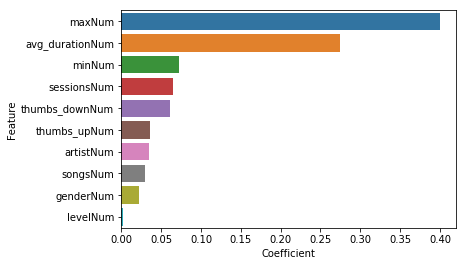

In [53]:
import matplotlib as plt
sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.iloc[:20]);

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.